In [1]:
import os
import ray
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
%load_ext watermark
%watermark

Last updated: 2024-02-21T01:11:01.567579+00:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.0-1033-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 192
Architecture: 64bit



In [3]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-02-21 01:11:03,742	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.13
Ray version:,2.9.2
Dashboard:,http://127.0.0.1:8265


In [4]:
ray.cluster_resources()

{'node:__internal_head__': 1.0,
 'memory': 588487691264.0,
 'object_store_memory': 200000000000.0,
 'accelerator_type:A10G': 1.0,
 'node:10.119.39.210': 1.0,
 'CPU': 192.0,
 'GPU': 8.0}

In [5]:
num_workers = 8
num_devices = 4
resources_per_worker = {"CPU": 8, "GPU": 1}

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

plt.rcParams["figure.dpi"] = 300
sns.set_theme(style="whitegrid")

## 🍲 Data

In [7]:
data_path = Path("../data/cafa5")

In [8]:
df = pd.read_parquet(data_path / "top100_train_split.parquet")
print(df.shape)
df.head()

(70921, 3)


,Entry ID,Sequence,Index
59837,Q75PL7,MPPNSVDKTNETEYLKDNHVDYEKLIAPQASPIKHKIVVMNVIRFS...,59837
12347,E9QA15,MDDFERRRELRRQKREEMRLEAERIAYQRNDDDEEEAARERRRRAR...,12347
62582,Q84TI3,MKRLRSSDDLDFCNDKNVDGEPPNSDRPASSSHRGFFSGNNRDRGE...,62582
47476,Q24060,MRYLCVFSLTLILCCLSIKAQSLNCTRLRENCRPCTRRLVDPINDL...,47476
40185,P84282,APECGREAHCGDDCQSQVVTRDFDDRTCPKLLCCSKDGWCGNTDAN...,40185


#### 🔍 EDA

In [9]:
seq_lens = df["Sequence"].str.len()
print(f"Sequence length min: {seq_lens.min()}, max: {seq_lens.max()}")

Sequence length min: 5, max: 35375


[Text(0.5, 0, 'Sequence Length')]

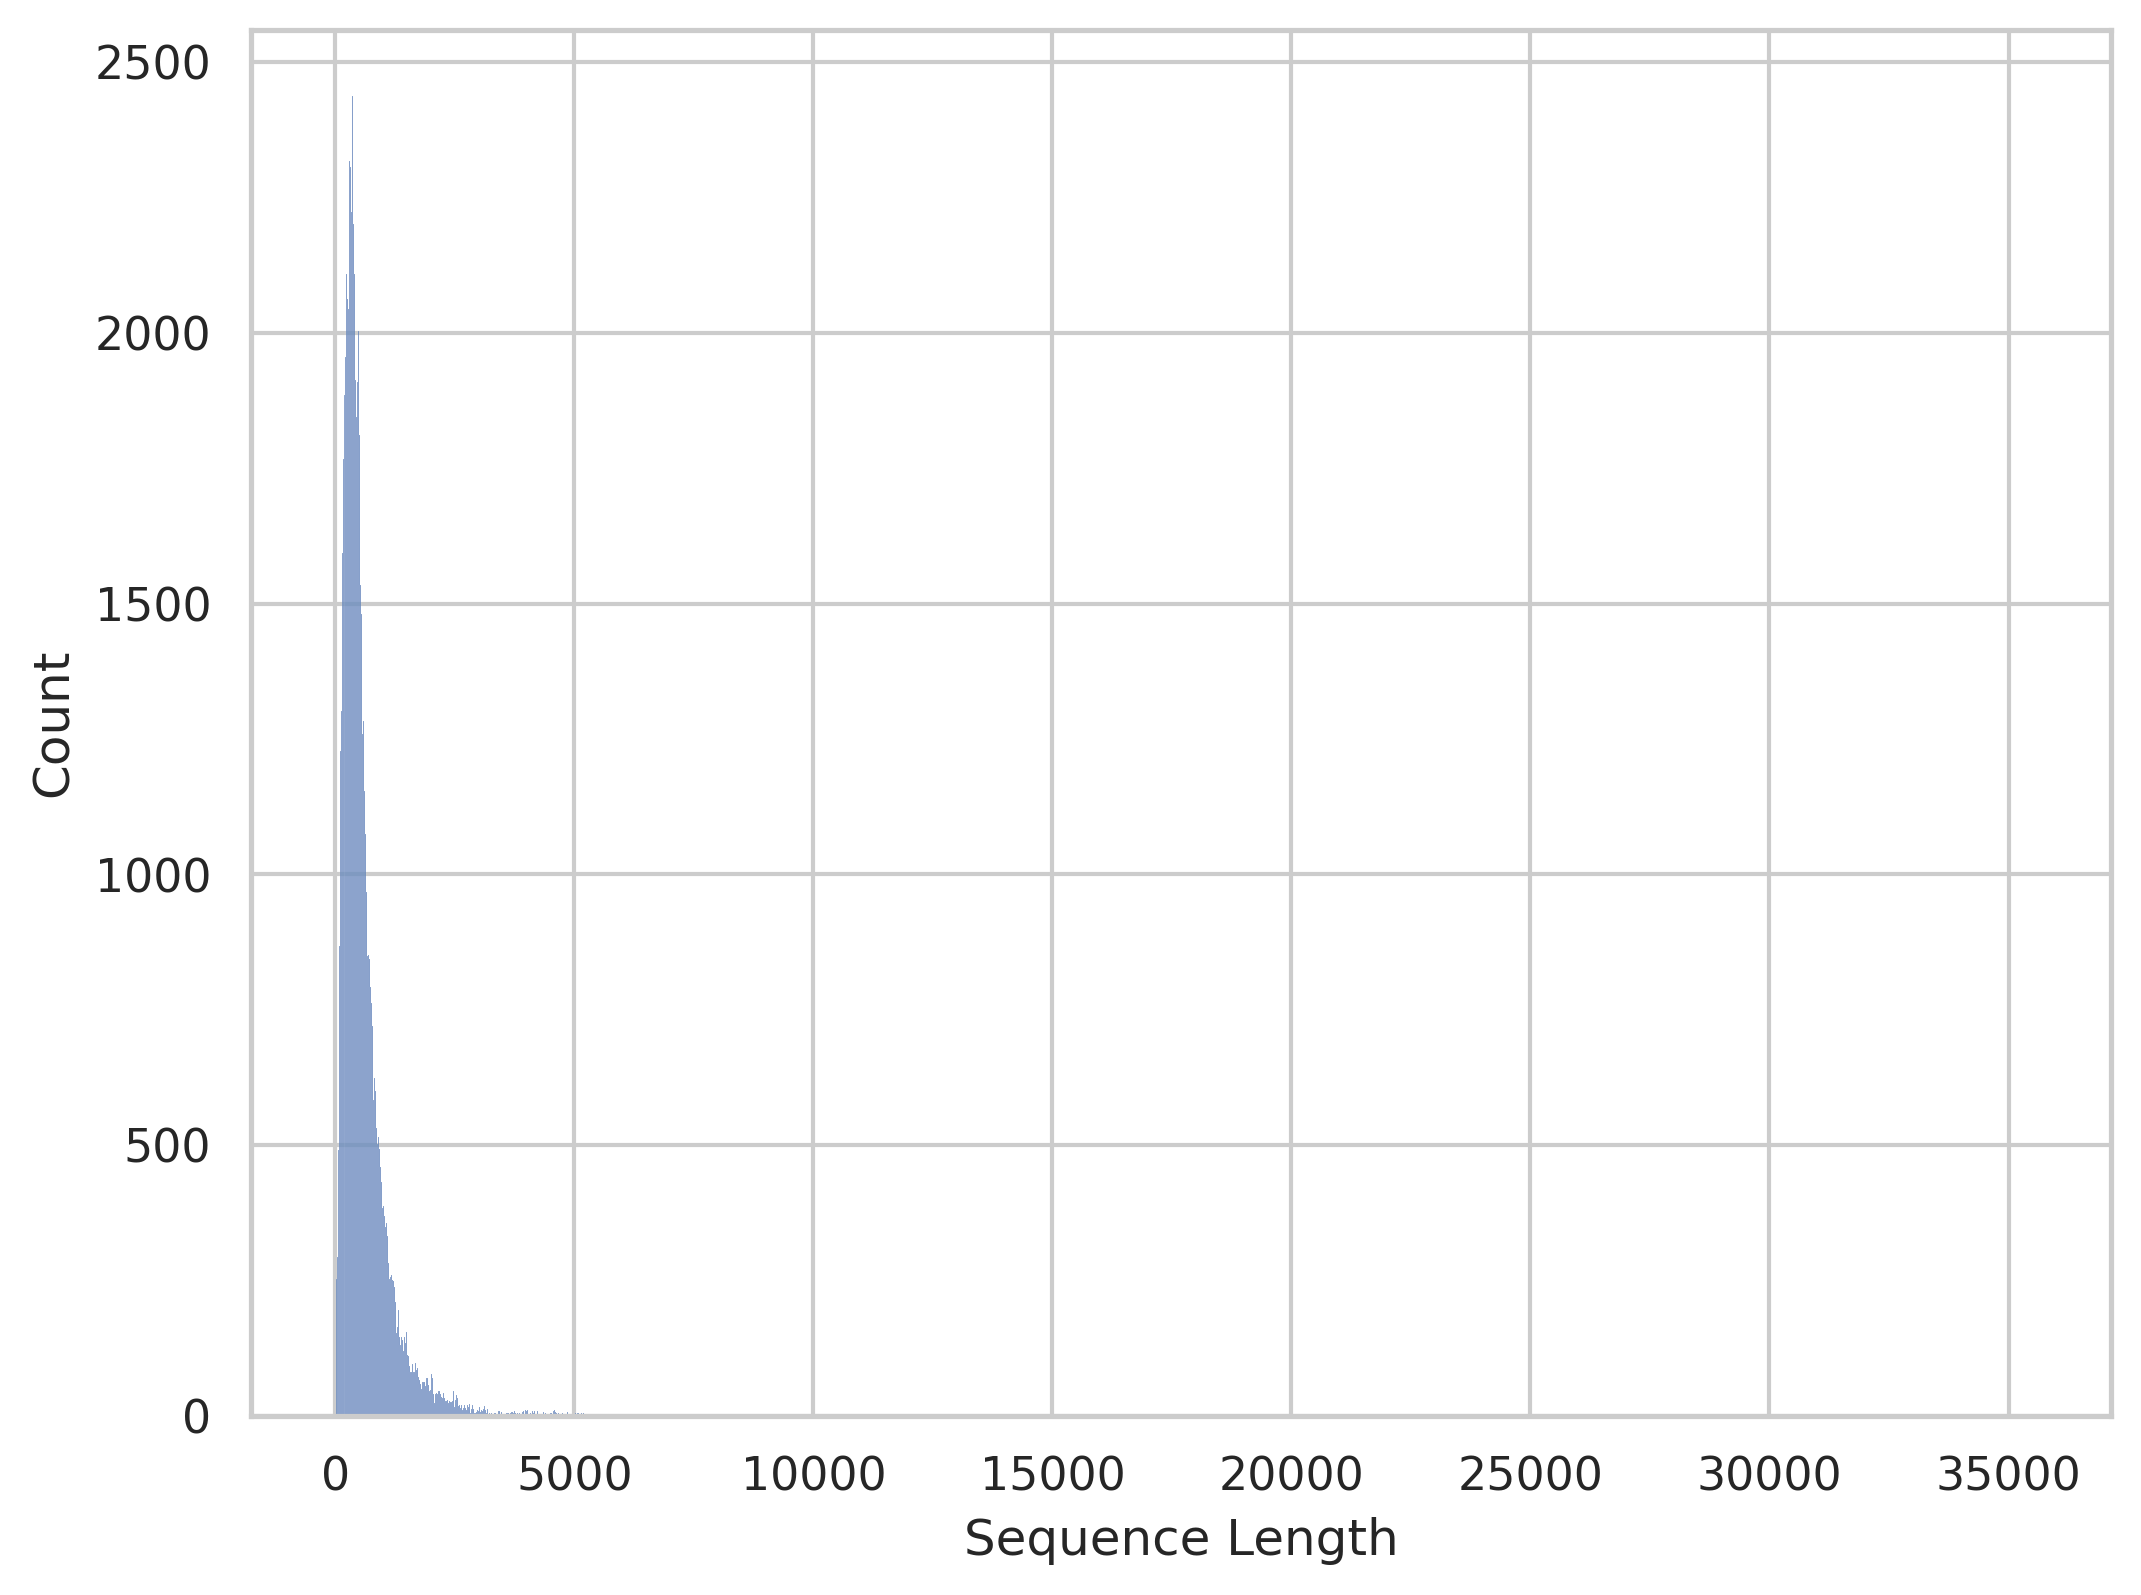

In [10]:
# protein length distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.histplot(data=seq_lens, ax=ax)
ax.set(xlabel="Sequence Length")

#### ✂️ Split Data

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# further split a validation set
valid_size = 0.25  # 0.8*0.25=0.2
train_df, valid_df = train_test_split(df, test_size=valid_size, random_state=0)

#### 🏭 Data Processing

In [13]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, EsmModel

In [14]:
model_name = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
seq = df["Sequence"].iloc[0]
len(seq)

330

In [16]:
seq

'MPPNSVDKTNETEYLKDNHVDYEKLIAPQASPIKHKIVVMNVIRFSYLHIAGLYGLYLCFTSAKLATSVFAIVLFFLGNFGITAGAHRLWSHNGYKVKLPLEILLMVFNSIAFQNTIFTWVRDHRLHHKYTDTDADPHNATRGFFFSHIGWLLVRKHPMVKIAGKSLDMSDIYCNPLLRFQKKYAIPFIGTICFIIPTLAPMYFWGESLNNAWHITVLRYIFSLNGTFLVNSAAHLWGYKPYDKSLKATQSGMANAFTFGEGFHNYHHVFPWDYRADELGDRYINLTTRFIDFFAWMGWAYDLKTASTNIIEKRALRTGDGTYKRPNGMN'

In [17]:
encoded_seq = tokenizer([seq], padding=False, truncation=True, return_tensors="np")
encoded_seq["input_ids"]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


array([[ 0, 20, 14, 14, 17,  8,  7, 13, 15, 11, 17,  9, 11,  9, 19,  4,
        15, 13, 17, 21,  7, 13, 19,  9, 15,  4, 12,  5, 14, 16,  5,  8,
        14, 12, 15, 21, 15, 12,  7,  7, 20, 17,  7, 12, 10, 18,  8, 19,
         4, 21, 12,  5,  6,  4, 19,  6,  4, 19,  4, 23, 18, 11,  8,  5,
        15,  4,  5, 11,  8,  7, 18,  5, 12,  7,  4, 18, 18,  4,  6, 17,
        18,  6, 12, 11,  5,  6,  5, 21, 10,  4, 22,  8, 21, 17,  6, 19,
        15,  7, 15,  4, 14,  4,  9, 12,  4,  4, 20,  7, 18, 17,  8, 12,
         5, 18, 16, 17, 11, 12, 18, 11, 22,  7, 10, 13, 21, 10,  4, 21,
        21, 15, 19, 11, 13, 11, 13,  5, 13, 14, 21, 17,  5, 11, 10,  6,
        18, 18, 18,  8, 21, 12,  6, 22,  4,  4,  7, 10, 15, 21, 14, 20,
         7, 15, 12,  5,  6, 15,  8,  4, 13, 20,  8, 13, 12, 19, 23, 17,
        14,  4,  4, 10, 18, 16, 15, 15, 19,  5, 12, 14, 18, 12,  6, 11,
        12, 23, 18, 12, 12, 14, 11,  4,  5, 14, 20, 19, 18, 22,  6,  9,
         8,  4, 17, 17,  5, 22, 21, 12, 11,  7,  4, 10, 19, 12, 

In [18]:
tokenizer.decode(encoded_seq["input_ids"][0])

'<cls> M P P N S V D K T N E T E Y L K D N H V D Y E K L I A P Q A S P I K H K I V V M N V I R F S Y L H I A G L Y G L Y L C F T S A K L A T S V F A I V L F F L G N F G I T A G A H R L W S H N G Y K V K L P L E I L L M V F N S I A F Q N T I F T W V R D H R L H H K Y T D T D A D P H N A T R G F F F S H I G W L L V R K H P M V K I A G K S L D M S D I Y C N P L L R F Q K K Y A I P F I G T I C F I I P T L A P M Y F W G E S L N N A W H I T V L R Y I F S L N G T F L V N S A A H L W G Y K P Y D K S L K A T Q S G M A N A F T F G E G F H N Y H H V F P W D Y R A D E L G D R Y I N L T T R F I D F F A W M G W A Y D L K T A S T N I I E K R A L R T G D G T Y K R P N G M N <eos>'

In [19]:
# targets
targets = np.load(data_path / "train_bp_top100_targets.npy")
targets.shape

(88652, 100)

In [20]:
def tokenize_seqs(batch, tokenizer, targets):
    encoded_seqs = tokenizer(
        batch["Sequence"].tolist(),
        padding="longest",
        truncation=True,
        max_length=min(1024, tokenizer.model_max_length),
        return_tensors="np",
    )
    return dict(
        input_ids=encoded_seqs["input_ids"],
        attention_mask=encoded_seqs["attention_mask"],
        targets=targets[batch["Index"].tolist()],
    )

In [21]:
tokenize_seqs(train_df.iloc[:10], tokenizer, targets)

{'input_ids': array([[ 0, 20,  9, ...,  1,  1,  1],
        [ 0, 20,  6, ...,  1,  1,  1],
        [ 0, 20,  5, ...,  1,  1,  1],
        ...,
        [ 0, 20, 13, ...,  1,  1,  1],
        [ 0, 20,  6, ...,  1,  1,  1],
        [ 0, 20,  9, ...,  1,  1,  1]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


#### ☁️ Distributed Processing

In [22]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = (
    True  # deterministic
)

In [23]:
ds = ray.data.read_parquet(data_path / "top100_train_split.parquet")
ds = ds.random_shuffle(seed=0)
ds.take(1)

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-21 01:11:15,423	INFO dataset.py:2488 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-02-21 01:11:15,430	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=384 for stage ReadParquet to satisfy parallelism at least twice the available number of CPUs (192).
2024-02-21 01:11:15,431	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 384, each read task output is split into 384 smaller blocks.
2024-02-21 01:11:15,432	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-02-21 01:11:15,432	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(ReadParquet->SplitBlocks(384) pid=39827) /opt/conda/envs/ml/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
(ReadParquet->SplitBlocks(384) pid=39827)   return transform_pyarrow.concat(tables)
(reduce pid=39802) /opt/conda/envs/ml/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
(reduce pid=39802)   return transform_pyarrow.concat(tables)
(ReadParquet->SplitBlocks(384) pid=38238) /opt/conda/envs/ml/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
(ReadParquet->SplitBlocks(384) pid=38238)   return transform_pyarrow.concat(tables)
(RayTrainWorker pid=64727) Setting up process group for: env:// [rank=0, world_size=8]
(RayTrainWorker pid=64734) [W Utils.hpp:133] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING 

[{'Entry ID': 'Q8L8Q7',
  'Sequence': 'MNILFSRFSFLLLFLCSWTSFTFTTTEAYDALDPYGNITIKWDIMSWTGDGYVAVVTIFNFQQYRHIEAPGWQLGWSWMKKEVIWSMVGGQATEQGDCSKFKGNIPHCCKKTPAIVDLLPGTPYNQQISNCCRGGVISAWAQDPATAISSFQISVGQSGTTNTTVRAPRNITLKAPGPGYTCGPAKLVKPSRFISADKRRKTQSLLTWNITCTYSQFLARKTPTCCVSLSAFYNETIVPCPTCSCGCQNSSQAGTCVDPKIASVVPALGKNNLEPLLQCTQHMCPIRVHWHVKTSYKEYWRVKVAITNFNYNMNYSQWNLVVQHPNFDNLTKLFSFNYKPLNPYLNINDTAMLWGIKFYNDFLSQAGPVGNVQSELLFQKNPLEFTFEKGWAFPRRIYFNGDNCVMPPPDSYPWLPNASPNIATSPFVILLITFLSVLILM',
  'Index': 66256,
  '__index_level_0__': 66256}]

In [24]:
test_size = 0.25
train_ds, val_ds = ds.train_test_split(test_size=test_size)

2024-02-21 01:11:20,352	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=384 for stage ReadParquet to satisfy parallelism at least twice the available number of CPUs (192).
2024-02-21 01:11:20,352	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 384, each read task output is split into 384 smaller blocks.
2024-02-21 01:11:20,353	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]
2024-02-21 01:11:20,354	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-21 01:11:20,354	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_curr

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-21 01:11:25,128	WARNING plan.py:588 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/latest/data/data-internals.html#ray-data-and-tune


In [25]:
sample_ds = train_ds.map_batches(
    tokenize_seqs,
    fn_kwargs={
        "tokenizer": tokenizer,
        "targets": targets,
    },
    batch_format="pandas",
)
sample_ds.show(1)

2024-02-21 01:11:25,281	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(tokenize_seqs)] -> LimitOperator[limit=1]
2024-02-21 01:11:25,282	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-21 01:11:25,283	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/289 [00:00<?, ?it/s]

{'input_ids': array([ 0, 20, 17, ...,  1,  1,  1]), 'attention_mask': array([1, 1, 1, ..., 0, 0, 0]), 'targets': array([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


## 🏃Training

In [26]:
import os
import json
import random

In [27]:
def set_seeds(seed=0):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [28]:
DATASET_LOC = data_path / "top100_train_split.parquet"


def load_data(num_samples=None):
    ds = ray.data.read_parquet(DATASET_LOC)
    ds = ds.random_shuffle(seed=0)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [29]:
class CustomPreprocessor:
    """Custom preprocessor class."""

    def transform(self, ds):
        return ds.map_batches(
            tokenize_seqs,
            fn_kwargs={
                "tokenizer": tokenizer,
                "targets": targets,
            },
            batch_format="pandas",
        )

#### 🤖 Model

In [30]:
llm = EsmModel.from_pretrained(model_name)
embedding_dim = llm.config.hidden_size
embedding_dim

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


640

In [31]:
pad_token_id = llm.config.pad_token_id
pad_token_id

1

In [32]:
# sample
batch = tokenizer([seq[:10], seq[10:30]], return_tensors="pt", padding="longest")
outputs = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0728,  0.0008,  0.1951,  ...,  0.0106, -0.1426,  0.0886],
         [-0.2240, -0.0293,  0.2990,  ...,  0.0525, -0.3503, -0.1196],
         [-0.3267, -0.1073,  0.1907,  ...,  0.1440, -0.4525, -0.1106],
         ...,
         [-0.1741, -0.0427,  0.0537,  ..., -0.0172, -0.2754,  0.0030],
         [-0.1811,  0.0604,  0.0618,  ...,  0.2024, -0.4184, -0.1326],
         [-0.1850,  0.0631,  0.0900,  ...,  0.1714, -0.4044, -0.1751]],

        [[-0.0635,  0.1431,  0.0786,  ...,  0.0329, -0.1369,  0.0488],
         [-0.1175, -0.0788,  0.1055,  ..., -0.1743, -0.2922,  0.0161],
         [-0.1525, -0.2163,  0.0350,  ...,  0.3948, -0.0685, -0.0096],
         ...,
         [ 0.0726, -0.1047, -0.0035,  ...,  0.2980, -0.3405, -0.1196],
         [-0.2075, -0.3430,  0.0491,  ...,  0.1677, -0.3820, -0.0385],
         [-0.0431,  0.1303, -0.0676,  ...,  0.0876, -0.2291,  0.1612]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_ou

In [33]:
last_hidden_state, pool = outputs.last_hidden_state, outputs.pooler_output
last_hidden_state.shape, pool.shape

(torch.Size([2, 22, 640]), torch.Size([2, 640]))

In [34]:
# mean pooling of last_hidden_state

# first expand the mask
mask = batch["attention_mask"].unsqueeze(-1).expand(last_hidden_state.shape).float()

# sum unmasked token embeddings
sum_embeddings = torch.sum(last_hidden_state * mask, dim=1)

# number of unmasked tokens for each sequence
# set a min value to avoid divide by zero
num_tokens = torch.clamp(mask.sum(1), min=1e-9)

# divide
mean_embeddings = sum_embeddings / num_tokens
mean_embeddings.shape

torch.Size([2, 640])

In [35]:
class FinetunedESM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super().__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = nn.Dropout(dropout_p)
        self.pre_classifier = nn.Linear(embedding_dim, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def mean_pooling(self, token_embeddings, attention_mask):
        """Average the embedding of all amino acids in a sequence"""

        # expand the mask
        expanded_mask = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.shape).float()
        )

        # sum unmasked token embeddings
        sum_embeddings = torch.sum(token_embeddings * expanded_mask, dim=1)

        # number of unmasked tokens for each sequence
        # set a min value to avoid divide by zero
        num_tokens = torch.clamp(expanded_mask.sum(1), min=1e-9)

        # divide
        mean_embeddings = sum_embeddings / num_tokens
        return mean_embeddings

    def forward(self, batch):
        input_ids, attention_mask = batch["input_ids"], batch["attention_mask"]

        # per token representations from the last layer
        token_embeddings = self.llm(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state

        # average per token representations
        mean_embeddings = self.mean_pooling(token_embeddings, attention_mask)

        # https://github.com/huggingface/transformers/blob/main/src/transformers/models/distilbert/modeling_distilbert.py
        mean_embeddings = self.pre_classifier(mean_embeddings)  # (bs, embedding_dim)
        mean_embeddings = nn.ReLU()(mean_embeddings)
        mean_embeddings = self.dropout(mean_embeddings)

        logits = self.classifier(mean_embeddings)  # (bs, num_classes)
        return logits

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        y = self(batch)
        return y.cpu().numpy()

    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

        torch.save(self.state_dict(), Path(dp) / "model.pt")

    @classmethod
    def load(cls, esm_model, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)

        llm = EsmModel.from_pretrained(esm_model)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(
            torch.load(state_dict_fp, map_location=torch.device("cpu"))
        )
        return model

In [36]:
num_classes = 100

# model = FinetunedESM(
#     llm=llm, dropout_p=0.1, embedding_dim=embedding_dim, num_classes=num_classes
# )
# print(model.parameters)

In [37]:
from ray.train.torch import get_device

get_device()

device(type='cuda', index=0)

In [38]:
def collate_fn(batch):
    padded = tokenizer.pad(
        {"input_ids": batch["input_ids"], "attention_mask": batch["attention_mask"]},
        return_tensors="pt",
    )

    batch["input_ids"] = padded["input_ids"].to(device=get_device())
    batch["attention_mask"] = padded["attention_mask"].to(device=get_device())
    batch["targets"] = torch.as_tensor(
        batch["targets"], dtype=torch.float, device=get_device()
    )

    return batch

In [39]:
sample_batch = sample_ds.take_batch(batch_size=8)
sample_batch

2024-02-21 01:11:32,279	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(tokenize_seqs)] -> LimitOperator[limit=8]
2024-02-21 01:11:32,280	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-21 01:11:32,281	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/289 [00:00<?, ?it/s]

{'input_ids': array([[ 0, 20, 17, ...,  1,  1,  1],
        [ 0, 20, 10, ...,  1,  1,  1],
        [ 0, 20,  8, ...,  1,  1,  1],
        ...,
        [ 0, 20,  6, ...,  1,  1,  1],
        [ 0, 20, 12, ...,  1,  1,  1],
        [ 0, 20,  5, ...,  1,  1,  1]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,


In [40]:
sample_batch = collate_fn(batch=sample_batch)
sample_batch

{'input_ids': tensor([[ 0, 20, 17,  ...,  1,  1,  1],
         [ 0, 20, 10,  ...,  1,  1,  1],
         [ 0, 20,  8,  ...,  1,  1,  1],
         ...,
         [ 0, 20,  6,  ...,  1,  1,  1],
         [ 0, 20, 12,  ...,  1,  1,  1],
         [ 0, 20,  5,  ...,  1,  1,  1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'targets': tensor([[1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
          0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 

In [41]:
ds = load_data()
train_ds, val_ds = ds.train_test_split(test_size=test_size)
preprocessor = CustomPreprocessor()
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-21 01:11:34,141	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=384 for stage ReadParquet to satisfy parallelism at least twice the available number of CPUs (192).
2024-02-21 01:11:34,142	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 384, each read task output is split into 384 smaller blocks.
2024-02-21 01:11:34,142	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]
2024-02-21 01:11:34,143	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-21 01:11:34,144	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_curr

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-21 01:11:38,937	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(tokenize_seqs)]
2024-02-21 01:11:38,939	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-21 01:11:38,939	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/289 [00:00<?, ?it/s]

2024-02-21 01:11:40,049	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(tokenize_seqs)]
2024-02-21 01:11:40,050	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-21 01:11:40,050	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/96 [00:00<?, ?it/s]

In [42]:
import lightning as L
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torchmetrics.functional.classification import multilabel_f1_score

In [43]:
L.seed_everything(0)

Seed set to 0


0

In [44]:
class ESMLightningModule(L.LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, batch):
        return self.model(batch)

    def training_step(self, batch, batch_idx):
        logits = self(batch)
        loss = self.loss_fn(logits, batch["targets"])
        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        logits = self(batch)
        loss = self.loss_fn(logits, batch["targets"])
        self.log("val_loss", loss, prog_bar=True)

        f1_score = multilabel_f1_score(
            logits, batch["targets"].type(torch.int), num_classes
        )
        self.log("val_f1_score", f1_score, prog_bar=True)

    def test_step(self, batch, batch_idx):
        logits = self(batch)

        f1_score = multilabel_f1_score(
            logits, batch["targets"].type(torch.int), num_classes
        )
        self.log("f1_score", f1_score, prog_bar=True)

    def configure_optimizers(self):
        if self.global_rank == 0:
            print(self.trainer.model)
        optimizer = torch.optim.Adam(
            self.trainer.model.parameters(), lr=self.learning_rate
        )
        return optimizer

In [45]:
import functools
from torch.distributed.fsdp.wrap import transformer_auto_wrap_policy
from torch.distributed.fsdp import ShardingStrategy, BackwardPrefetch
from ray.train.lightning import RayFSDPStrategy
from transformers.models.esm.modeling_esm import EsmLayer

In [46]:
auto_wrap_policy = functools.partial(
    transformer_auto_wrap_policy, transformer_layer_cls={EsmLayer}
)

fsdp_strategy = RayFSDPStrategy(
    sharding_strategy=ShardingStrategy.FULL_SHARD,
    backward_prefetch=BackwardPrefetch.BACKWARD_PRE,
    forward_prefetch=True,
    auto_wrap_policy=auto_wrap_policy,
    limit_all_gathers=True,
    activation_checkpointing_policy={EsmLayer},
)

In [47]:
from ray.train import Checkpoint
from ray.train.lightning import (
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)

In [48]:
def train_loop_per_worker(config):
    # Hyperparameters
    esm_model = config["esm_model"]
    dropout_p = config["dropout_p"]
    strategy = config["strategy"]
    lr = config["lr"]
    num_epochs = config["num_epochs"]
    batch_size_per_worker = config["batch_size_per_worker"]
    num_classes = config["num_classes"]

    train_ds = ray.train.get_dataset_shard("train")
    val_ds = ray.train.get_dataset_shard("val")
    train_loader = train_ds.iter_torch_batches(
        batch_size=batch_size_per_worker, collate_fn=collate_fn
    )
    val_loader = val_ds.iter_torch_batches(
        batch_size=batch_size_per_worker, collate_fn=collate_fn
    )

    llm = EsmModel.from_pretrained(esm_model)
    model = FinetunedESM(
        llm=llm,
        dropout_p=dropout_p,
        embedding_dim=llm.config.hidden_size,
        num_classes=num_classes,
    )
    lightning_model = ESMLightningModule(model, lr)

    trainer = pl.Trainer(
        max_epochs=num_epochs,
        devices=num_devices,
        accelerator="cuda",
        precision="16-mixed",
        strategy=strategy,
        plugins=[RayLightningEnvironment()],
        callbacks=[RayTrainReportCallback()],
        enable_checkpointing=True,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(
        lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader
    )

In [49]:
from ray.train.torch import TorchTrainer
from ray.train import RunConfig, ScalingConfig, CheckpointConfig

In [50]:
storage_path = str(Path().resolve() / "finetune_results")

In [51]:
run_config = RunConfig(
    name="finetune_esm_all_layers",
    storage_path=storage_path,
    checkpoint_config=CheckpointConfig(num_to_keep=1),
)

In [52]:
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=True,
    # resources_per_worker=resources_per_worker,
)

In [53]:
# Train loop config
train_loop_config = {
    "esm_model": model_name,
    "dropout_p": 0.1,
    "strategy": fsdp_strategy,
    "lr": 1e-3,
    "num_epochs": 1,
    "batch_size_per_worker": 4,
    "num_classes": num_classes,
}

In [54]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
)

In [55]:
%%time
# Train
results = trainer.fit()

(RayTrainWorker pid=64727) FullyShardedDataParallel(
(RayTrainWorker pid=64727)   (_fsdp_wrapped_module): ESMLightningModule(
(RayTrainWorker pid=64727)     (model): FinetunedESM(
(RayTrainWorker pid=64727)       (llm): EsmModel(
(RayTrainWorker pid=64727)         (embeddings): EsmEmbeddings(
(RayTrainWorker pid=64727)           (word_embeddings): Embedding(33, 640, padding_idx=1)
(RayTrainWorker pid=64727)           (dropout): Dropout(p=0.0, inplace=False)
(RayTrainWorker pid=64727)           (position_embeddings): Embedding(1026, 640, padding_idx=1)
(RayTrainWorker pid=64727)         )
(RayTrainWorker pid=64727)         (encoder): EsmEncoder(
(RayTrainWorker pid=64727)           (layer): ModuleList(
(RayTrainWorker pid=64727)             (0-29): 30 x FullyShardedDataParallel(
(RayTrainWorker pid=64727)               (_fsdp_wrapped_module): CheckpointWrapper(
(RayTrainWorker pid=64727)                 (_checkpoint_wrapped_module): EsmLayer(
(RayTrainWorker pid=64727)                  

(RayTrainWorker pid=64727) 
(RayTrainWorker pid=64727)   | Name    | Type              | Params
(RayTrainWorker pid=64727) ----------------------------------------------
(RayTrainWorker pid=64727) 0 | model   | FinetunedESM      | 18.7 M
(RayTrainWorker pid=64727) 1 | loss_fn | BCEWithLogitsLoss | 0     
(RayTrainWorker pid=64727) ----------------------------------------------
(RayTrainWorker pid=64727) 18.7 M    Trainable params
(RayTrainWorker pid=64727) 0         Non-trainable params
(RayTrainWorker pid=64727) 18.7 M    Total params
(RayTrainWorker pid=64727) 74.635    Total estimated model params size (MB)
(SplitCoordinator pid=65562) Auto configuring locality_with_output=['c9d98ffcb7233057bf28ba232c325fbbe7c629d75f739544d6b66a8d', 'c9d98ffcb7233057bf28ba232c325fbbe7c629d75f739544d6b66a8d', 'c9d98ffcb7233057bf28ba232c325fbbe7c629d75f739544d6b66a8d', 'c9d98ffcb7233057bf28ba232c325fbbe7c629d75f739544d6b66a8d', 'c9d98ffcb7233057bf28ba232c325fbbe7c629d75f739544d6b66a8d', 'c9d98ffcb7233

(pid=65562) Running 0:   0%|          | 0/96 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:02<00:00,  0.78it/s]
                                                                           
Epoch 0: |          | 0/? [00:00<?, ?it/s] 


(RayTrainWorker pid=64727) /opt/conda/envs/ml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=64734) Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight'] [repeated 7x across cluster]
(RayTrainWorker pid=64734) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference. [repeated 7x across cluster]
(RayTrainWorker pid=64727) /opt/conda/envs/ml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_f1_score', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the me

(pid=65561) Running 0:   0%|          | 0/289 [00:00<?, ?it/s]

Epoch 0: |          | 1/? [00:02<00:00,  0.50it/s, v_num=0]
Epoch 0: |          | 2/? [00:03<00:00,  0.51it/s, v_num=0]
Epoch 0: |          | 3/? [00:05<00:00,  0.52it/s, v_num=0]
Epoch 0: |          | 4/? [00:07<00:00,  0.52it/s, v_num=0]
Epoch 0: |          | 5/? [00:09<00:00,  0.52it/s, v_num=0]
Epoch 0: |          | 6/? [00:11<00:00,  0.53it/s, v_num=0]
Epoch 0: |          | 7/? [00:13<00:00,  0.53it/s, v_num=0]
Epoch 0: |          | 8/? [00:15<00:00,  0.53it/s, v_num=0]
Epoch 0: |          | 9/? [00:17<00:00,  0.53it/s, v_num=0]
Epoch 0: |          | 10/? [00:18<00:00,  0.53it/s, v_num=0]
Epoch 0: |          | 11/? [00:20<00:00,  0.52it/s, v_num=0]
Epoch 0: |          | 12/? [00:22<00:00,  0.52it/s, v_num=0]
Epoch 0: |          | 13/? [00:24<00:00,  0.52it/s, v_num=0]
Epoch 0: |          | 14/? [00:26<00:00,  0.52it/s, v_num=0]
Epoch 0: |          | 15/? [00:28<00:00,  0.52it/s, v_num=0]
Epoch 0: |          | 16/? [00:30<00:00,  0.52it/s, v_num=0]
Epoch 0: |          | 17/? [00:32

(RayTrainWorker pid=64733) Missing logger folder: /home/ubuntu/ray_results/finetune_esm_all_layers/TorchTrainer_2d046_00000_0_2024-02-21_01-11-43/lightning_logs [repeated 7x across cluster]
(RayTrainWorker pid=64729) LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] [repeated 7x across cluster]
(SplitCoordinator pid=65562) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(8, equal=True)] [repeated 2x across cluster]
(SplitCoordinator pid=65562) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=1.0, gpu=8.0, object_store_memory=0.0), locality_with_output=['c9d98ffcb7233057bf28ba232c325fbbe7c629d75f739544d6b66a8d', 'c9d98ffcb7233057bf28ba232c325fbbe7c629d75f739544d6b66a8d', 'c9d98ffcb7233057bf28ba232c325fbbe7c629d75f739544d6b66a8d', 'c9d98ffcb7233057bf28ba232c325fbbe7c629d75f739544d6b66a8d', 'c9d98ffcb7233057bf28ba232c325fbbe7c629d75f739544d6b66a8d', 'c9d98ffcb7233

(pid=65562) Running 0:   0%|          | 0/96 [00:00<?, ?it/s]

(RayTrainWorker pid=64727) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=64727) 
Validation DataLoader 0: |          | 1/? [00:00<00:00,  1.46it/s]
(RayTrainWorker pid=64727) 
Validation DataLoader 0: |          | 2/? [00:01<00:00,  1.46it/s]
(RayTrainWorker pid=64727) 
Validation DataLoader 0: |          | 3/? [00:02<00:00,  1.46it/s]
(RayTrainWorker pid=64727) 
Validation DataLoader 0: |          | 4/? [00:02<00:00,  1.46it/s]
(RayTrainWorker pid=64727) 
Validation DataLoader 0: |          | 5/? [00:03<00:00,  1.46it/s]
(RayTrainWorker pid=64727) 
Validation DataLoader 0: |          | 6/? [00:04<00:00,  1.46it/s]
(RayTrainWorker pid=64727) 
Validation DataLoader 0: |          | 7/? [00:04<00:00,  1.46it/s]
(RayTrainWorker pid=64727) 
Validation DataLoader 0: |          | 8/? [00:05<00:00,  1.46it/s]
(RayTrainWorker pid=64727) 
Validation DataLoader 0: |       

(RayTrainWorker pid=64727) [rank0]:[2024-02-21 02:10:39,672] torch.distributed.fsdp._optim_utils: [WARNING] CUDA Memory Summary before calling to _allgather_orig_param_states |===========================================================================|
(RayTrainWorker pid=64727) [rank0]:[2024-02-21 02:10:39,672] torch.distributed.fsdp._optim_utils: [WARNING] |                  PyTorch CUDA memory summary, device ID 0                 |
(RayTrainWorker pid=64727) [rank0]:[2024-02-21 02:10:39,672] torch.distributed.fsdp._optim_utils: [WARNING] |---------------------------------------------------------------------------|
(RayTrainWorker pid=64727) [rank0]:[2024-02-21 02:10:39,672] torch.distributed.fsdp._optim_utils: [WARNING] |            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
(RayTrainWorker pid=64727) [rank0]:[2024-02-21 02:10:39,672] torch.distributed.fsdp._optim_utils: [WARNING] |===========================================================================|
(Ra

Epoch 0: |          | 1662/? [58:57<00:00,  0.47it/s, v_num=0, val_loss=0.382, val_f1_score=0.0179]


(RayTrainWorker pid=64727) [rank0]:[2024-02-21 02:11:00,354] torch.distributed.fsdp._optim_utils: [WARNING] CUDA Memory Summary before calling to _allgather_orig_param_states |===========================================================================|
(RayTrainWorker pid=64727) [rank0]:[2024-02-21 02:11:00,354] torch.distributed.fsdp._optim_utils: [WARNING] |                  PyTorch CUDA memory summary, device ID 0                 |
(RayTrainWorker pid=64727) [rank0]:[2024-02-21 02:11:00,354] torch.distributed.fsdp._optim_utils: [WARNING] |---------------------------------------------------------------------------|
(RayTrainWorker pid=64727) [rank0]:[2024-02-21 02:11:00,354] torch.distributed.fsdp._optim_utils: [WARNING] |            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
(RayTrainWorker pid=64727) [rank0]:[2024-02-21 02:11:00,354] torch.distributed.fsdp._optim_utils: [WARNING] |===========================================================================|
(Ra

Epoch 0: |          | 1662/? [59:02<00:00,  0.47it/s, v_num=0, val_loss=0.382, val_f1_score=0.0179]


(RayTrainWorker pid=64727) `Trainer.fit` stopped: `max_epochs=1` reached.


2024-02-21 02:11:08,229	WARNING experiment_state.py:323 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
2024-02-21 02:11:08,235	INFO tune.py:1042 -- Total run time: 3564.63 seconds (3561.97 seconds for the tuning loop).


CPU times: user 24.6 s, sys: 13.6 s, total: 38.2 s
Wall time: 59min 24s


In [56]:
results.metrics_dataframe

,train_loss,val_loss,val_f1_score,epoch,step,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,...,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/esm_model,config/train_loop_config/dropout_p,config/train_loop_config/strategy,config/train_loop_config/lr,config/train_loop_config/num_epochs,config/train_loop_config/batch_size_per_worker,config/train_loop_config/num_classes
0,0.495151,0.381992,0.017857,0,1662,1708481443,checkpoint_000000,True,False,1,...,10.119.39.210,3550.605845,1,facebook/esm2_t30_150M_UR50D,0.1,<ray.train.lightning._lightning_utils.RayFSDPS...,0.001,1,4,100


In [57]:
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/home/ubuntu/projects/github/esm-finetune/notebooks/finetune_results/finetune_esm_all_layers/TorchTrainer_2d046_00000_0_2024-02-21_01-11-43/checkpoint_000000),
  {'train_loss': 0.4951508343219757,
   'val_loss': 0.38199183344841003,
   'val_f1_score': 0.017856836318969727,
   'epoch': 0,
   'step': 1662,
   'timestamp': 1708481443,
   'checkpoint_dir_name': 'checkpoint_000000',
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 1,
   'trial_id': '2d046_00000',
   'date': '2024-02-21_02-10-58',
   'time_this_iter_s': 3550.605844974518,
   'time_total_s': 3550.605844974518,
   'pid': 64612,
   'hostname': 'ip-10-119-39-210',
   'node_ip': '10.119.39.210',
   'config': {'train_loop_config': {'esm_model': 'facebook/esm2_t30_150M_UR50D',
     'dropout_p': 0.1,
     'strategy': <ray.train.lightning._lightning_utils.RayFSDPStrategy at 0x7ef091621870>,
     'lr': 0.001,
     'num_epochs': 1,
     'batch_size_per_worker': 4,
     'num_cl